1.)  First, import all of the libraries we might need.

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.tree import export_graphviz
import graphviz
from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix


2.) Load the dataset.  Note: In doing some research online I verified that Class = 1 means that the bank note is authentic. 

In [2]:
billauth_df = pd.read_csv("bill_authentication.csv")
billauth_df.head()

,Variance,Skewness,Curtosis,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


3.)  Divide dataset into train and test sets

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(billauth_df.drop('Class', axis=1), billauth_df['Class'], test_size=0.2, random_state=122)


3.) First let's create our 'full tree' without restricting any of the hyperparameters.  We'll fit the tree using the train dataset.

In [10]:
full_tree = DecisionTreeClassifier(random_state=123)
full_tree.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

4.)  Now we'll make some predictions with this full tree, and calculate accuracy score to get a baseline for how well it performed.

In [11]:
predictions = full_tree.predict(X_test)

In [12]:
accuracy_score(Y_test,predictions)

0.9854545454545455

In [9]:
#dot_data = export_graphviz(full_tree, filled=True, rounded=True, feature_names=X_train.columns, out_file=None)
#graphviz.Source(dot_data)

I'm a little suprised that when testing the full tree on the test dataset, that the accuracy was so high.  My fear is that there's still overfitting happening, as in visualizing the tree it is quite large.  I want to go through the pruning exercise to see if I can get soemthing that seems more reasonable.

5.)  Next, I'll use Gridsearch to find the optimal number of hyperparameters to use in my decision
tree.  Will try out several different combinations.  Will use 10 folds for cross validation.

In [13]:
param_grid = [{"max_features":[None,1,2,3],"max_depth":[3, 4, 5, 6,7,8,None],"min_samples_split":[10,25,50,75,100]}]
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=122), param_grid = param_grid, cv=10)

6.)  Now, will fit the data on the train set, and print out the different combinations that Gridsearch has tried...(note since there were so many different combinations I commented this step out for purposes of submitting assignment.)

In [14]:
gs.fit(X_train, Y_train)
#gs.cv_results_['params']  

C:\Users\Todd\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=122,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_features': [None, 1, 2, 3], 'max_depth': [3, 4, 5, 6, 7, 8, None], 'min_samples_split': [10, 25, 50, 75, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

...and will print the best hyperparameter combination.

In [15]:
gs.best_params_

{'max_depth': 6, 'max_features': 3, 'min_samples_split': 10}

From the output, it looks like the best combination of hyperparameters to use is a tree with max depth = 6, maximum features = 3, and minimum samples required for any split to be 10.  

7.)  Now we can use these hyperparameter values to create a new 'pruned' tree.  Let's also visualize this as now the tree will be a reasonable size that we can look at.

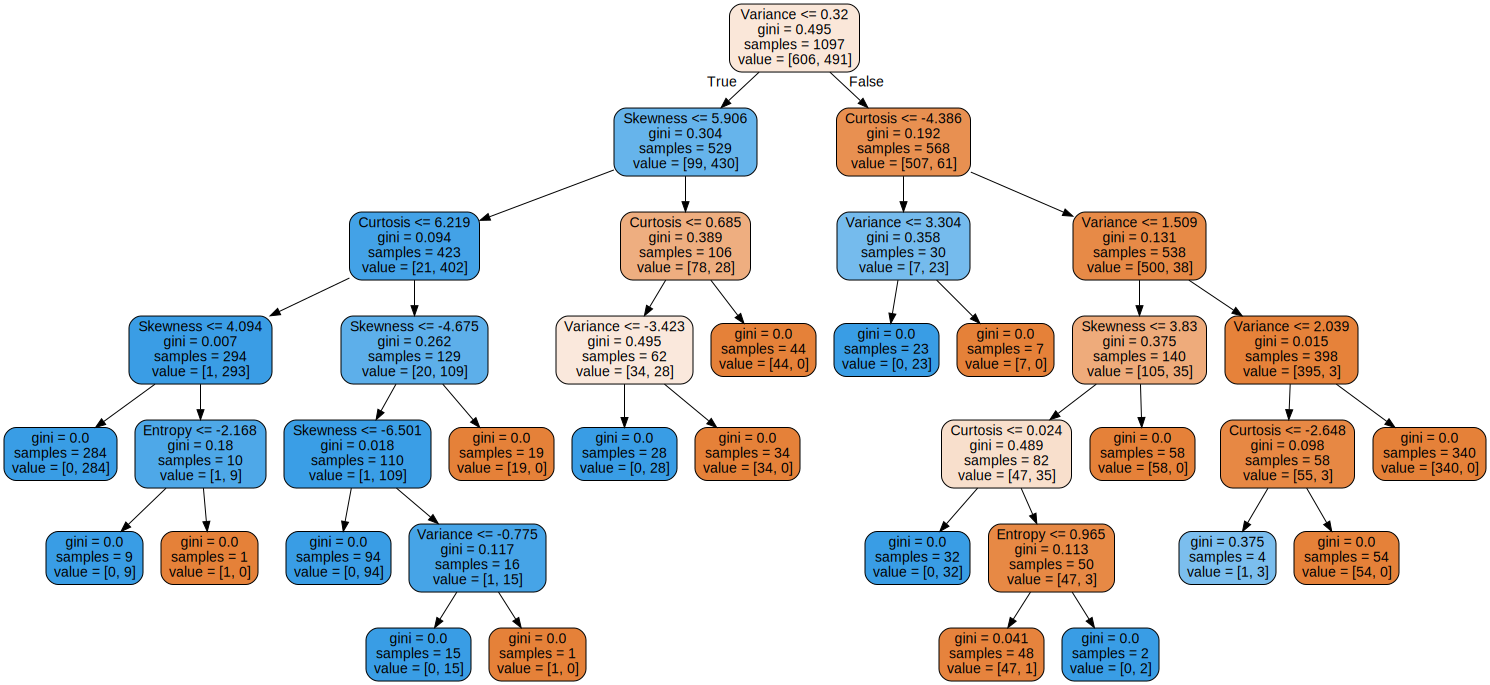

In [16]:
cut_tree = gs.best_estimator_
dot_data = export_graphviz(cut_tree, filled=True, rounded=True, feature_names=X_train.columns, out_file=None)
graphviz.Source(dot_data)

8.)  Now we'll look at how well this new pruned tree does on the test dataset.

In [17]:
predictions = cut_tree.predict(X_test)

In [18]:
accuracy_score(Y_test,predictions)

0.9672727272727273

As we can see, the accuracy score is actually somewhat lower than with the full tree.  And the pruned tree itself is basically about as large as the full tree.  Therefore in this instance I might actually stick with the full tree.

I wouldn't mind some feedback around my logic here, as I'm not 100% confident in this result.  But based on the accuracy criteria I'm not sure how else to come to a different result.  Is it common depending on the nature of the problem that sometimes a full (or close to full tree) with very specific/stringent criteria for branching can be a good model to go with?  For example in this case, maybe the technology of imaging is so advanced/accurate that this is reasonable to correctly identify the response class this way?   